In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from resnet_cifar10 import resnet_20, resnet_32, resnet_44, resnet_56, resnet_110

In [2]:
# GPU 사용 시 GPU memory 사용량 조절 부분
# 이 코드를 사용하면 GPU memory 가 충분히 남아있을 경우 여러 코드를 동시에 처리할 수 있다.

GPU_DEVICE_NUM = 0 # Multi GPU를 이용할 경우 사용하고자 할 GPU ID
gpus = tf.config.experimental.list_physical_devices('GPU')
print('='*16)
print('Current gpu devices : {}'.format(gpus))
print('='*16)

if gpus :
    try :
        #tf.config.experimental.set_visible_devices(gpus[GPU_DEVICE_NUM], 'GPU')  # Multi GPU 사용 시 주석 제거
        tf.config.experimental.set_memory_growth(gpus[GPU_DEVICE_NUM], True)
    except RuntimeError as e :
        print(e)

Current gpu devices : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# 학습 및 테스트용 CIFAR-10 데이터셋 로드
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# 결과 저장 경로
TRAINED_MODEL_PATH = 'models_resnet20'

# Class 개수와 이미지 크기 지정
NUM_CLASSES = 10            # CIFAR-10 Dataset 은 10개의 class 를 가지고 있음
IMG_HEIGHT = 32             # CIFAR-10 Dataset 의 이미지 크기 32x32x3
IMG_WIDTH = 32

# Epoch 횟수와 batch size, learning rate, dropout ratio 지정
EPOCHS = 200                 # 학습 반복 횟수 지정
BATCH_SIZE = 32            # 학습에 사용할 mini-batch 크기
LEARNING_RATE = 0.001       # Optimizer 에 사용할 learning rate

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [4]:
# One-hot encoding 형태로 label 데이터 변경
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

print(y_train.shape, y_test.shape)

# ImageDataGenerator pipeline 을 이용한 Data augmentation
# 학습용 데이터셋을 augmentation 하기 위한 ImageDataGenerator pipeline
datagen = ImageDataGenerator(
            featurewise_center=True,               # 각 이미지의 평균값에서 전체 데이터셋의 평균값을 빼서 분포의 평균을 0에 가깝게 만듦
            featurewise_std_normalization=True,    # 평균이 0이고 분산이 1인 정규 분포를 따르도록 정규화
            horizontal_flip=True,                  # random horizontal flip
            width_shift_range=0.125,               # 좌/우로 이미지를 이동시켜 학습 데이터 늘림(0.125 : 전체 가로 크기의 12.5% 범위 내)
            height_shift_range=0.125,              # 상/하로 이미지를 이동시켜 학습 데이터 늘림(0.125 : 전체 세로 크기의 12.5% 범위 내)
            validation_split=0.2)                  # validation 에 사용할 데이터 비율(20%)

# 테스트용 데이터셋을 augmentation 하기 위한 ImageDataGenerator pipeline
test_datagen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True)

# featurewise_center / featurewise_std_normalization 은 전체 데이터셋을 사용하여야 함으로
# ImageDataGenerator.fit() 을 통해 전체 데이터셋을 확인해야함
datagen.fit(x_train)
test_datagen.fit(x_test)

(50000, 10) (10000, 10)


In [5]:
# ResNet-20 모델 생성
model = resnet_20(NUM_CLASSES)

# 학습에 사용할 SGD optimizer 및 loss function 생성
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
losses = tf.keras.losses.CategoricalCrossentropy()

# 모델 컴파일(optimizer, loss 지정)
model.compile(optimizer=optimizer,
              loss=losses,
              metrics=['acc'])

In [6]:
# Learning rate scheduler 함수
def lr_scheduler(epoch) :
    # epoch이 진행됨에 따라 learning rate를 조절함
    learning_rate = LEARNING_RATE
    if epoch >= 80 :
        learning_rate = LEARNING_RATE * 0.1
    if epoch >= 120 :
        learning_rate = LEARNING_RATE * 0.01
    return learning_rate

# Keras 에서 제공하는 LearningRateScheduler를 통해 callback 생성
lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

if os.path.exists(TRAINED_MODEL_PATH) is False :
    os.makedirs(TRAINED_MODEL_PATH)
    
# Checkpoint 저장을 위한 callback
# TRAINED_MODEL_PATH 에 'val_acc' 기준으로 최대값이 갱신될 때마다 저장하도록 구현
save_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=TRAINED_MODEL_PATH,
                monitor='val_acc', verbose=1, save_best_only=True,
                save_weights_only=False, mode='max', save_freq='epoch')

# 필요한 callback 을 list 로 지정
callback_list = [lr, save_callback]

history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, subset='training'),
                    # 학습에 사용할 데이터 : 미리 만들어둔 ImageDataGenerator pipeline에 x_train, y_train 입력하여 사용
                    # subset = 'training' 으로 학습용 데이터라는 것을 pipeline에 알려주어야함
                   validation_data=datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
                    # 검증에 사용할 데이터 : 미리 만들어둔 ImageDataGenerator pipeline에 x_train, y_train 입력하여 사용
                    # subset = 'validation' 으로 검증용 데이터라는 것을 pipeline에 알려주어야함
                    epochs=EPOCHS,              # epoch 횟수 입력
                    shuffle=True,               # 매 epoch 학습 시작 전 데이터셋 무작위로 배치
                    callbacks=[callback_list])  # 매 epoch이 종료될 때 호출할 callback 함수 지정



Epoch 1/200
1250/1250 [==============================] - 39s 29ms/step - loss: 1.7675 - acc: 0.3484 - val_loss: 1.5466 - val_acc: 0.4268

Epoch 00001: val_acc improved from -inf to 0.42680, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 2/200
1250/1250 [==============================] - 34s 27ms/step - loss: 1.4548 - acc: 0.4681 - val_loss: 1.4207 - val_acc: 0.4967

Epoch 00002: val_acc improved from 0.42680 to 0.49670, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 3/200
1250/1250 [==============================] - 35s 28ms/step - loss: 1.2938 - acc: 0.5329 - val_loss: 1.3116 - val_acc: 0.5325

Epoch 00003: val_acc improved from 0.49670 to 0.53250, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 4/200
1250/1250 [==============================] - 35s 28ms/step - loss: 1.1604 - acc: 0.5845 - val_loss: 1.1260 - val_acc: 0.6067

Epoch 00004: val_acc improved from 0.53250 to 0.60670, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 5/200
1250/1250 [==============================] - 35s 28ms/step - loss: 1.0688 - acc: 0.6194 - val_loss: 1.2260 - val_acc: 0.5675

Epoch 00005: val_acc did not improve from 0.60670
Epoch 6/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.9893 - acc: 0.6496 - val_loss: 0.9851 - val_acc: 0.6558

Epoch 00006: val_acc improved from 0.60670 to 0.65580, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 7/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.9313 - acc: 0.6700 - val_loss: 0.9226 - val_acc: 0.6729

Epoch 00007: val_acc improved from 0.65580 to 0.67290, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 8/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.8674 - acc: 0.6957 - val_loss: 0.9603 - val_acc: 0.6662

Epoch 00008: val_acc did not improve from 0.67290
Epoch 9/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.8261 - acc: 0.7091 - val_loss: 0.9251 - val_acc: 0.6808

Epoch 00009: val_acc improved from 0.67290 to 0.68080, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 10/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.7809 - acc: 0.7275 - val_loss: 0.8897 - val_acc: 0.6876

Epoch 00010: val_acc improved from 0.68080 to 0.68760, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 11/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.7461 - acc: 0.7402 - val_loss: 0.7652 - val_acc: 0.7278

Epoch 00011: val_acc improved from 0.68760 to 0.72780, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 12/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.7160 - acc: 0.7517 - val_loss: 0.9492 - val_acc: 0.6830

Epoch 00012: val_acc did not improve from 0.72780
Epoch 13/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.6824 - acc: 0.7638 - val_loss: 0.7715 - val_acc: 0.7408

Epoch 00013: val_acc improved from 0.72780 to 0.74080, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 14/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.6590 - acc: 0.7727 - val_loss: 0.8183 - val_acc: 0.7211

Epoch 00014: val_acc did not improve from 0.74080
Epoch 15/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.6344 - acc: 0.7799 - val_loss: 0.6981 - val_acc: 0.7591

Epoch 00015: val_acc improved from 0.74080 to 0.75910, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 16/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.6165 - acc: 0.7846 - val_loss: 0.6996 - val_acc: 0.7582

Epoch 00016: val_acc did not improve from 0.75910
Epoch 17/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.5948 - acc: 0.7933 - val_loss: 0.6842 - val_acc: 0.7620

Epoch 00017: val_acc improved from 0.75910 to 0.76200, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 18/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.5740 - acc: 0.8026 - val_loss: 0.7085 - val_acc: 0.7548

Epoch 00018: val_acc did not improve from 0.76200
Epoch 19/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.5540 - acc: 0.8073 - val_loss: 0.6577 - val_acc: 0.7741

Epoch 00019: val_acc improved from 0.76200 to 0.77410, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 20/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.5452 - acc: 0.8107 - val_loss: 0.6636 - val_acc: 0.7741

Epoch 00020: val_acc did not improve from 0.77410
Epoch 21/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.5302 - acc: 0.8169 - val_loss: 0.5982 - val_acc: 0.7913

Epoch 00021: val_acc improved from 0.77410 to 0.79130, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 22/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.5067 - acc: 0.8252 - val_loss: 0.5978 - val_acc: 0.8022

Epoch 00022: val_acc improved from 0.79130 to 0.80220, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 23/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.5006 - acc: 0.8251 - val_loss: 0.5974 - val_acc: 0.7982

Epoch 00023: val_acc did not improve from 0.80220
Epoch 24/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.4891 - acc: 0.8293 - val_loss: 0.5810 - val_acc: 0.7999

Epoch 00024: val_acc did not improve from 0.80220
Epoch 25/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.4758 - acc: 0.8339 - val_loss: 0.5959 - val_acc: 0.7975

Epoch 00025: val_acc did not improve from 0.80220
Epoch 26/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.4632 - acc: 0.8384 - val_loss: 0.6036 - val_acc: 0.7975

Epoch 00026: val_acc did not improve from 0.80220
Epoch 27/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.4509 - acc: 0.8446 - val_loss: 0.5872 - val_acc: 0.7969

Epoch 00027: val_acc did not improve from 0.80220
Epoch 28/200
1250/1250 [==============================]

INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 29/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.4320 - acc: 0.8508 - val_loss: 0.6517 - val_acc: 0.7862

Epoch 00029: val_acc did not improve from 0.80510
Epoch 30/200
1250/1250 [==============================] - 34s 28ms/step - loss: 0.4250 - acc: 0.8533 - val_loss: 0.5638 - val_acc: 0.8054

Epoch 00030: val_acc improved from 0.80510 to 0.80540, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 31/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.4085 - acc: 0.8579 - val_loss: 0.7255 - val_acc: 0.7646

Epoch 00031: val_acc did not improve from 0.80540
Epoch 32/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.4029 - acc: 0.8583 - val_loss: 0.5182 - val_acc: 0.8233

Epoch 00032: val_acc improved from 0.80540 to 0.82330, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 33/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.3951 - acc: 0.8614 - val_loss: 0.5606 - val_acc: 0.8146

Epoch 00033: val_acc did not improve from 0.82330
Epoch 34/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.3804 - acc: 0.8689 - val_loss: 0.5508 - val_acc: 0.8131

Epoch 00034: val_acc did not improve from 0.82330
Epoch 35/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.3797 - acc: 0.8676 - val_loss: 0.5214 - val_acc: 0.8210

Epoch 00035: val_acc did not improve from 0.82330
Epoch 36/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.3663 - acc: 0.8726 - val_loss: 0.5213 - val_acc: 0.8278

Epoch 00036: val_acc improved from 0.82330 to 0.82780, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 37/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.3634 - acc: 0.8744 - val_loss: 0.5789 - val_acc: 0.8114

Epoch 00037: val_acc did not improve from 0.82780
Epoch 38/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.3596 - acc: 0.8753 - val_loss: 0.6092 - val_acc: 0.8068

Epoch 00038: val_acc did not improve from 0.82780
Epoch 39/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.3528 - acc: 0.8775 - val_loss: 0.5846 - val_acc: 0.8069

Epoch 00039: val_acc did not improve from 0.82780
Epoch 40/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.3396 - acc: 0.8813 - val_loss: 0.6671 - val_acc: 0.7843

Epoch 00040: val_acc did not improve from 0.82780
Epoch 41/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.3380 - acc: 0.8813 - val_loss: 0.5444 - val_acc: 0.8245

Epoch 00041: val_acc did not improve from 0.82780
Epoch 42/200
1250/1250 [==============================]

INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 48/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.2977 - acc: 0.8956 - val_loss: 0.5267 - val_acc: 0.8255

Epoch 00048: val_acc did not improve from 0.83500
Epoch 49/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.2885 - acc: 0.8991 - val_loss: 0.6499 - val_acc: 0.7909

Epoch 00049: val_acc did not improve from 0.83500
Epoch 50/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.2874 - acc: 0.8976 - val_loss: 0.5212 - val_acc: 0.8299

Epoch 00050: val_acc did not improve from 0.83500
Epoch 51/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.2749 - acc: 0.9039 - val_loss: 0.5344 - val_acc: 0.8320

Epoch 00051: val_acc did not improve from 0.83500
Epoch 52/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.2797 - acc: 0.9022 - val_loss: 0.5022 - val_acc: 0.8346

Epoch 00052: val_acc did not improve from 0.83500
Epoch 53/200
1250/1250 [==============================]

INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 55/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.2616 - acc: 0.9079 - val_loss: 0.5948 - val_acc: 0.8190

Epoch 00055: val_acc did not improve from 0.85660
Epoch 56/200
1250/1250 [==============================] - 34s 28ms/step - loss: 0.2546 - acc: 0.9112 - val_loss: 0.4714 - val_acc: 0.8442

Epoch 00056: val_acc did not improve from 0.85660
Epoch 57/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.2557 - acc: 0.9091 - val_loss: 0.5141 - val_acc: 0.8368

Epoch 00057: val_acc did not improve from 0.85660
Epoch 58/200
1250/1250 [==============================] - 34s 27ms/step - loss: 0.2504 - acc: 0.9109 - val_loss: 0.4998 - val_acc: 0.8400

Epoch 00058: val_acc did not improve from 0.85660
Epoch 59/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.2356 - acc: 0.9176 - val_loss: 0.4595 - val_acc: 0.8541

Epoch 00059: val_acc did not improve from 0.85660
Epoch 60/200
1250/1250 [==============================]

INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 82/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1238 - acc: 0.9575 - val_loss: 0.3986 - val_acc: 0.8785

Epoch 00082: val_acc improved from 0.86860 to 0.87850, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 83/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1161 - acc: 0.9604 - val_loss: 0.4069 - val_acc: 0.8802

Epoch 00083: val_acc improved from 0.87850 to 0.88020, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 84/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1115 - acc: 0.9622 - val_loss: 0.3921 - val_acc: 0.8810

Epoch 00084: val_acc improved from 0.88020 to 0.88100, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 85/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1104 - acc: 0.9617 - val_loss: 0.3935 - val_acc: 0.8812

Epoch 00085: val_acc improved from 0.88100 to 0.88120, saving model to models_resnet20


INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 86/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1076 - acc: 0.9635 - val_loss: 0.3997 - val_acc: 0.8759

Epoch 00086: val_acc did not improve from 0.88120
Epoch 87/200
1250/1250 [==============================] - 36s 28ms/step - loss: 0.1071 - acc: 0.9643 - val_loss: 0.4134 - val_acc: 0.8766

Epoch 00087: val_acc did not improve from 0.88120
Epoch 88/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1094 - acc: 0.9623 - val_loss: 0.4031 - val_acc: 0.8793

Epoch 00088: val_acc did not improve from 0.88120
Epoch 89/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1059 - acc: 0.9636 - val_loss: 0.4038 - val_acc: 0.8769

Epoch 00089: val_acc did not improve from 0.88120
Epoch 90/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1051 - acc: 0.9636 - val_loss: 0.4013 - val_acc: 0.8793

Epoch 00090: val_acc did not improve from 0.88120
Epoch 91/200
1250/1250 [==============================]

INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 95/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1009 - acc: 0.9659 - val_loss: 0.4052 - val_acc: 0.8782

Epoch 00095: val_acc did not improve from 0.88300
Epoch 96/200
1250/1250 [==============================] - 34s 27ms/step - loss: 0.0965 - acc: 0.9674 - val_loss: 0.4185 - val_acc: 0.8726

Epoch 00096: val_acc did not improve from 0.88300
Epoch 97/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0971 - acc: 0.9677 - val_loss: 0.4028 - val_acc: 0.8819

Epoch 00097: val_acc did not improve from 0.88300
Epoch 98/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0952 - acc: 0.9668 - val_loss: 0.4065 - val_acc: 0.8799

Epoch 00098: val_acc did not improve from 0.88300
Epoch 99/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0971 - acc: 0.9675 - val_loss: 0.4051 - val_acc: 0.8808

Epoch 00099: val_acc did not improve from 0.88300
Epoch 100/200
1250/1250 [==============================

INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 117/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0844 - acc: 0.9722 - val_loss: 0.4122 - val_acc: 0.8789

Epoch 00117: val_acc did not improve from 0.88390
Epoch 118/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0830 - acc: 0.9716 - val_loss: 0.4244 - val_acc: 0.8744

Epoch 00118: val_acc did not improve from 0.88390
Epoch 119/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0857 - acc: 0.9711 - val_loss: 0.4288 - val_acc: 0.8792

Epoch 00119: val_acc did not improve from 0.88390
Epoch 120/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0860 - acc: 0.9703 - val_loss: 0.4249 - val_acc: 0.8793

Epoch 00120: val_acc did not improve from 0.88390
Epoch 121/200
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0807 - acc: 0.9730 - val_loss: 0.4228 - val_acc: 0.8811

Epoch 00121: val_acc did not improve from 0.88390
Epoch 122/200
1250/1250 [=========================

INFO:tensorflow:Assets written to: models_resnet20\assets


INFO:tensorflow:Assets written to: models_resnet20\assets


Epoch 155/200
1250/1250 [==============================] - 34s 27ms/step - loss: 0.0751 - acc: 0.9746 - val_loss: 0.4292 - val_acc: 0.8791

Epoch 00155: val_acc did not improve from 0.88770
Epoch 156/200
1250/1250 [==============================] - 34s 27ms/step - loss: 0.0766 - acc: 0.9738 - val_loss: 0.4031 - val_acc: 0.8871

Epoch 00156: val_acc did not improve from 0.88770
Epoch 157/200
1250/1250 [==============================] - 34s 27ms/step - loss: 0.0746 - acc: 0.9748 - val_loss: 0.4279 - val_acc: 0.8769

Epoch 00157: val_acc did not improve from 0.88770
Epoch 158/200
1250/1250 [==============================] - 34s 27ms/step - loss: 0.0775 - acc: 0.9742 - val_loss: 0.4253 - val_acc: 0.8762

Epoch 00158: val_acc did not improve from 0.88770
Epoch 159/200
1250/1250 [==============================] - 34s 27ms/step - loss: 0.0753 - acc: 0.9743 - val_loss: 0.4259 - val_acc: 0.8826

Epoch 00159: val_acc did not improve from 0.88770
Epoch 160/200
1250/1250 [=========================

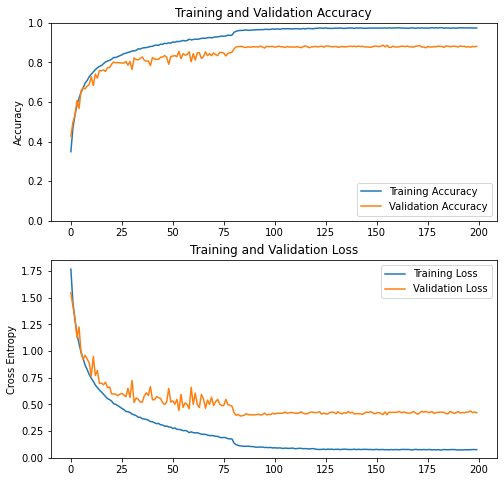

In [7]:
# Training accuracy 및 validation accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

# Training loss 및 validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# matplotlib 를 이용하여 accuracy 및 loss 출력
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [8]:
# Test 데이터를 이용한 학습 모델 검증
test_loss, test_acc = model.evaluate(
                        test_datagen.flow(x_test, y_test, batch_size=1),
                        verbose=1)
print('Test Loss : {:.4f}, Test Accuracy : {:.2f}%'.format(test_loss, 100.*test_acc))

10000/10000 [==============================] - 94s 9ms/step - loss: 0.4638 - acc: 0.8769
Test Loss : 0.4638, Test Accuracy : 87.69%
